## Create Request for Data Type warning

In [1]:
from awips.dataaccess import DataAccessLayer
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

DataAccessLayer.changeEDEXHost('edex-cloud.unidata.ucar.edu')
request = DataAccessLayer.newDataRequest()
request.setDatatype("warning")
request.setParameters('act','countyheader', 'endtime','etn','floodbegin', 
                      'floodcrest', 'floodend','floodrecordstatus', 
                      'floodseverity', 'id', 'immediatecause', 'inserttime', 
                      'issuetime', 'loc', 'locationid', 'motdir', 'motspd', 
                      'overviewtext', 'phen', 'phensig', 'pil', 'productclass',
                      'purgetime', 'rawmessage', 'seg', 'segtext', 'sig', 
                      'starttime', 'ugczones', 'vtecstr', 'wmoid', 'xxxid')
response = DataAccessLayer.getGeometryData(request)
print(str(len(response)) + " records")

433 records


#### Create a dictionary of lists for each parameter

In [2]:
parameters = {}
for x in request.getParameters():
    parameters[x] = np.array([])
geometries=np.array([])
siteid=np.array([])
period=np.array([])
reftime=np.array([])

for ob in response:
    for parm in parameters:
        parameters[parm] = np.append(parameters[parm],ob.getString(parm))
    geometries = np.append(geometries,ob.getGeometry())
    siteid = np.append(siteid,str(ob.getLocationName()))
    period = np.append(period,ob.getDataTime().getValidPeriod())
    reftime = np.append(reftime,ob.getDataTime().getRefTime())

print("Using " + str(len(geometries)) + " geometries.")
print(request.getParameters())

Using 433 geometries.
['act', 'countyheader', 'endtime', 'etn', 'floodbegin', 'floodcrest', 'floodend', 'floodrecordstatus', 'floodseverity', 'id', 'immediatecause', 'inserttime', 'issuetime', 'loc', 'locationid', 'motdir', 'motspd', 'overviewtext', 'phen', 'phensig', 'pil', 'productclass', 'purgetime', 'rawmessage', 'seg', 'segtext', 'sig', 'starttime', 'ugczones', 'vtecstr', 'wmoid', 'xxxid']


#### Print out basic info for each warning

In [15]:
for i, val in enumerate(geometries):
    issue = datetime.fromtimestamp(
        float(int(parameters['issuetime'][i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    purge = datetime.fromtimestamp(
        float(int(parameters['purgetime'][i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    start = datetime.fromtimestamp(
        float(int(parameters['starttime'][i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    end = datetime.fromtimestamp(
        float(int(parameters['endtime'][i])/1000)
    ).strftime('%Y-%m-%d %H:%M:%S')
    
if parameters['phensig'][i]:
    print(parameters['phensig'][i])  
print(siteid[i] +": "+ str(parameters['wmoid'][i]) \
      + "\nissued " + issue \
      + "\nstart " + start \
      + "\nend " + end \
      + "\npurge " + purge \
      + "\n" + str(geometries[i]) + "\n")

FL.W
KMKX: WGUS83 KMKX 042104
issued 2017-02-04 14:04:00
start 2017-02-04 14:04:00
end 2017-02-07 23:00:00
purge 2017-02-05 02:04:00
POLYGON ((-89.7 43.51, -89.66 43.65, -89.37 43.59, -89.39 43.39, -89.65000000000001 43.44, -89.56999999999999 43.5, -89.7 43.51))



## Plot Warning Polygons

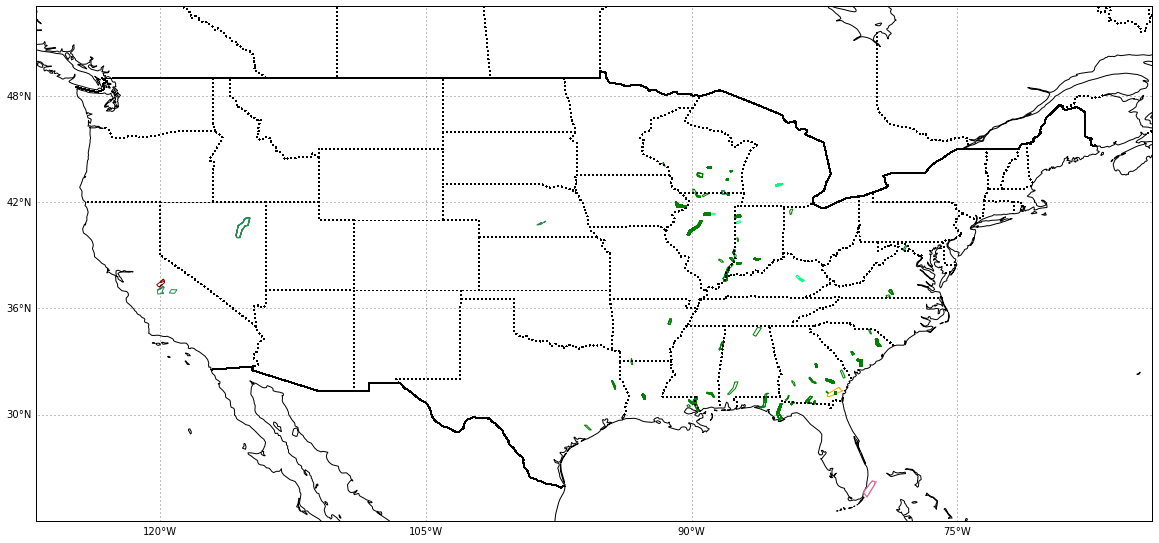

In [6]:
import cartopy.feature as cfeat
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import Polygon
from awips.tables import vtec

def warning_color(phensig):
    if vtec[phensig]['color']:
        return vtec[phensig]['color']

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

%matplotlib inline
bbox=[-127,-64,24,49]
fig, ax = make_map(bbox=bbox)
for i, geom in enumerate(geometries):
    bounds = Polygon(geom)
    intersection = bounds.intersection
    geoms = (intersection(geom)
         for geom in geometries
         if bounds.intersects(geom))
    
    # For now do not plot SPS
    if (parameters['phensig'][i]):
        color = warning_color(parameters['phensig'][i].astype('U13'))
        shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', edgecolor=color)
        ax.add_feature(shape_feature)


political_boundaries = NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')
ax.add_feature(political_boundaries, linestyle='-')
ax.add_feature(states, linestyle=':')
plt.show()

## Warning Polygons Plotted Over Level 3 Radar

In [13]:
from awips import ThriftClient, RadarCommon
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest
from datetime import timedelta
from numpy import ma
from metpy.plots import ctables

site = 'khnx'
request = DataAccessLayer.newDataRequest()
request.setDatatype('radar')
request.setLocationNames(site)

# Get latest time for site
datatimes = DataAccessLayer.getAvailableTimes(request)
dateTimeStr = str(datatimes[-1])
buffer = 60
dateTime = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S')
beginRange = dateTime - timedelta(0, buffer)
endRange = dateTime + timedelta(0, buffer)
timerange = TimeRange(beginRange, endRange)

# GetRadarDataRecordRequest to query site with timerange
client = ThriftClient.ThriftClient('edex-cloud.unidata.ucar.edu')
request = GetRadarDataRecordRequest()
request.setTimeRange(timerange)
request.setRadarId(site)

nexrad = {}
nexrad["N0Q"] = {
    'id': 94,
    'unit':'dBZ',
    'name':'0.5 deg Base Reflectivity',
    'ctable': ['NWSStormClearReflectivity',-20., 0.5],
    'res': 1000.,
    'elev': '0.5'
}

grids = []
for code in nexrad:
    request.setProductCode(nexrad[code]['id'])
    request.setPrimaryElevationAngle(nexrad[code]['elev'])
    response = client.sendRequest(request)

    if response.getData():
        for record in response.getData():
            # Get record hdf5 data
            idra = record.getHdf5Data()
            rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
            dim = rdat.getDimension()
            lat,lon = float(record.getLatitude()),float(record.getLongitude())
            radials,rangeGates = rdat.getSizes()

            # Convert raw byte to pixel value
            rawValue=np.array(rdat.getByteData())
            array = []
            for rec in rawValue:
                if rec<0:
                    rec+=256
                array.append(rec)

            if azdat:
                azVals = azdat.getFloatData()
                az = np.array(RadarCommon.encode_radial(azVals))
                dattyp = RadarCommon.get_data_type(azdat)
                az = np.append(az,az[-1])

            header = RadarCommon.get_header(record, format, rangeGates, radials, azdat, 'description')
            rng = np.linspace(0, rangeGates, rangeGates + 1)

            # Convert az/range to a lat/lon
            from pyproj import Geod
            g = Geod(ellps='clrk66')
            center_lat = np.ones([len(az),len(rng)])*lat
            center_lon = np.ones([len(az),len(rng)])*lon
            az2D = np.ones_like(center_lat)*az[:,None]
            rng2D = np.ones_like(center_lat)*np.transpose(rng[:,None])*nexrad[code]['res']
            lons,lats,back=g.fwd(center_lon,center_lat,az2D,rng2D)
            bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

            # Create 2d array
            multiArray = np.reshape(array, (-1, rangeGates))
            data = ma.array(multiArray)

            # threshVals[0:2] contains halfwords 31,32,33 (min value, increment, num levels)
            data = ma.array(threshVals[0]/10. + (multiArray)*threshVals[1]/10.)

            if nexrad[code]['unit'] == 'kts':
                data[data<-63] = ma.masked
                data *= 1.94384 # Convert to knots
            else:
                data[data<=((threshVals[0]/10.)+threshVals[1]/10.)] = ma.masked

            # Save our requested grids so we can render them multiple times
            product = {
                "code": code,
                "bbox": bbox,
                "lats": lats,
                "lons": lons,
                "data": data
            }
            grids.append(product)

print("Processed "+str(len(grids))+" grid.")

Processed 1 grid.


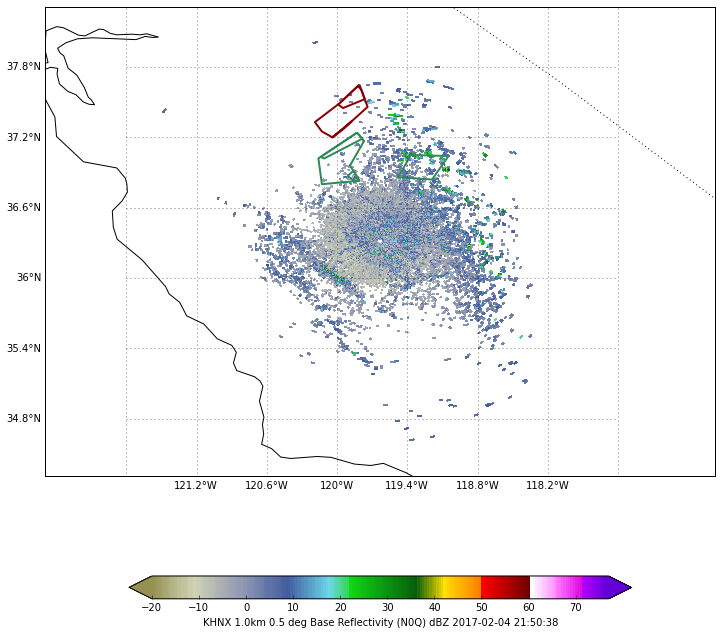

In [11]:
import cartopy.feature as cfeat
from cartopy.feature import ShapelyFeature
from shapely.geometry import Polygon

for rec in grids:
    code = rec["code"]
    bbox = rec["bbox"]
    lats = rec["lats"]
    lons = rec["lons"]
    data = rec["data"]
    # Create figure
    %matplotlib inline
    fig, ax = make_map(bbox=bbox)
    # Colortable filename, beginning value, increment
    ctable = nexrad[code]['ctable'][0]
    beg = nexrad[code]['ctable'][1]
    inc = nexrad[code]['ctable'][2]

    norm, cmap = ctables.registry.get_with_steps(ctable, beg, inc)
    cs = ax.pcolormesh(lons, lats, data, norm=norm, cmap=cmap)
    ax.set_aspect('equal', 'datalim')

    cbar = plt.colorbar(cs, extend='both', shrink=0.75, orientation='horizontal')
    cbar.set_label(site.upper()+" "+ str(nexrad[code]['res']/1000.) +"km " \
                   +nexrad[code]['name']+" ("+code+") " \
                   +nexrad[code]['unit']+" " \
                   +str(record.getDataTime()))

    # Zoom to within +- some value deg of center
    ax.set_xlim(lon-4., lon+4.)
    ax.set_ylim(lat-4., lat+4.)
    for i, geom in enumerate(geometries):
        bounds = Polygon(geom)
        intersection = bounds.intersection
        geoms = (intersection(geom)
             for geom in geometries
             if bounds.intersects(geom))

        # For now do not plot SPS
        if (parameters['phensig'][i]):
            color = warning_color(parameters['phensig'][i].astype('U13'))
            shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(),
                            linewidth=2,
                            facecolor='none', edgecolor=color)
            ax.add_feature(shape_feature)


    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='50m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')
    ax.add_feature(political_boundaries, linestyle='-')
    ax.add_feature(states, linestyle=':')
    plt.show()